# Model

The brake benchmark models an electro-mechanical braking system where a motor pushes a
brake caliber against a brake disk that is connected to a (car) wheel [?]. 

The model describes a
closed-loop system comprising a plant model and a controller, and the model is representative
of challenges in automotive systems. The original Simulink model has been simplified for usage
in various analysis tools. 

Here we consider a linearized version with parameters.
The model is a hybrid automaton with four state variables (the motor current I,
the brake position x, and two auxiliary linearization variables) and a clock variable T . 

The
automaton consists of a single mode and a self-loop transition. The transition is time triggered,
i.e., it only depends on the value of the clock variable.

![](EMBrake_model.png)

The following figure represents the Hybrid automaton of the electro-mechanical brake plant with periodic discrete-time
PI controller and sampling jitter.

In [1]:
using Revise, ReachabilityAnalysis, BenchmarkTools, SparseArrays, Plots;

┌ Warning: Replacing docs for `LazySets.Approximations.overapproximate :: Union{Tuple{S}, Tuple{T}, Tuple{Array{TaylorModels.TaylorModel1{T,S},1},Type{var"#s24"} where var"#s24"<:Zonotope}} where S where T` in module `LazySets.Approximations`
└ @ Base.Docs docs/Docs.jl:227
┌ Warning: Replacing docs for `LazySets.Approximations.overapproximate :: Union{Tuple{S}, Tuple{T}, Tuple{N}, Tuple{Array{TaylorModels.TaylorModelN{N,T,S},1},Type{var"#s22"} where var"#s22"<:Zonotope}} where S where T where N` in module `LazySets.Approximations`
└ @ Base.Docs docs/Docs.jl:227


In [2]:
LazySets.set_rtol(Float64, 1e-13)
LazySets.set_ztol(Float64, 1e-13)

# model without parameter variation
function embrake_no_pv(; Tsample=1.E-4, ζ=1e-6, x0=0.05)
    # model's constants
    L = 1.e-3
    KP = 10000.
    KI = 1000.
    R = 0.5
    K = 0.02
    drot = 0.1
    i = 113.1167

    # state variables: [I, x, xe, xc]
    A = Matrix([-(R+K^2/drot)/L 0      KP/L  KI/L;
                          K/i/drot      0      0      0;
                          0             0      0      0;
                          0             0      0      0])

    EMbrake = @system(x' = Ax)

    # initial conditions
    I₀  = Singleton([0.0])
    x₀  = Singleton([0.0])
    xe₀ = Singleton([0.0])
    xc₀ = Singleton([0.0])
    X₀ = I₀ × x₀ × xe₀ × xc₀

    # reset map
    Ar = sparse([1, 2, 3, 4, 4], [1, 2, 2, 2, 4], [1., 1., -1., -Tsample, 1.], 4, 4)
    br = sparsevec([3, 4], [x0, Tsample*x0], 4)
    reset_map(X) = Ar * X + br

    # hybrid system with clocked linear dynamics
    ha = HACLD1(EMbrake, reset_map, Tsample, ζ)
    return IVP(ha, X₀)
end

embrake_no_pv (generic function with 1 method)

In [3]:
# model with parameter variation changing only 1 coefficient, corresponds to the Flow* settings in [SO15]
function embrake_pv_1(; Tsample=1.E-4, ζ=1e-6, Δ=3.0, x0=0.05)
    # model's constants
    L = 1.e-3
    KP = 10000.
    KI = 1000.
    R = 0.5
    K = 0.02
    drot = 0.1
    i = 113.1167
    p = 504. + (-Δ .. Δ)

    # state variables: [I, x, xe, xc]
    A = IntervalMatrix([-p            0      KP/L   KI/L;
                        K/i/drot      0      0      0;
                        0             0      0      0;
                        0             0      0      0])

    EMbrake = @system(x' = Ax)

    # initial conditions
    I₀  = Singleton([0.0])
    x₀  = Singleton([0.0])
    xe₀ = Singleton([0.0])
    xc₀ = Singleton([0.0])
    X₀ = I₀ × x₀ × xe₀ × xc₀

    # reset map
    Ar = sparse([1, 2, 3, 4, 4], [1, 2, 2, 2, 4], [1., 1., -1., -Tsample, 1.], 4, 4)
    br = sparsevec([3, 4], [x0, Tsample*x0], 4)
    reset_map(X) = Ar * X + br

    # hybrid system with clocked linear dynamics
    ha = HACLD1(EMbrake, reset_map, Tsample, ζ)
    return IVP(ha, X₀)
end

embrake_pv_1 (generic function with 1 method)

### Specifications

# Reachability settings

# Results

In [4]:
# definitions for the safety properties

# const 
eₓ = sparsevec([2], [1.], 4);
x0 = 0.05;

## BRKDC01

In [57]:
sol_no_pv_no_jit = nothing
prob_no_pv_no_jit = embrake_no_pv(ζ=0., Tsample=1e-4);

In [58]:
@time sol_no_pv_no_jit = solve(prob_no_pv_no_jit, max_jumps=1001,
                               alg=GLGM06(δ=1e-7, max_order=1, static=true, dim=4, ngens=4));
GC.gc()
@show ρ(eₓ, sol_no_pv_no_jit)
ρ(eₓ, sol_no_pv_no_jit) < x0

  0.348624 seconds (261.72 k allocations: 228.737 MiB)
ρ(eₓ, sol_no_pv_no_jit) = 0.04928529955907948


true

In [88]:
sfpos = []
sfneg = []
times = []

for fp in sol_no_pv_no_jit
    for (j, X) in enumerate(fp)
        push!(sfpos, ρ(eₓ, X))
        push!(sfneg, ρ(-eₓ, X))
        push!(times, tspan(fp, j))
    end
end

In [72]:
length(sfpos)

1003002

In [79]:
LazySets.set_rtol(Float64, 1e-14)
LazySets.set_ztol(Float64, 1e-14)

1.0e-14

In [90]:
polys = [VPolygon([ [inf(times[i]), sfpos[i]],
                  [inf(times[i]), -sfneg[i]],
                  [sup(times[i]), sfpos[i]],
                  [sup(times[i]), -sfneg[i]]]) for i in 1:length(sfpos)];

In [89]:
times[end]

[0.1002, 0.100201]

In [ ]:
plot([X for X in polys[1:1000:end]], xlab="t", ylab="x", 

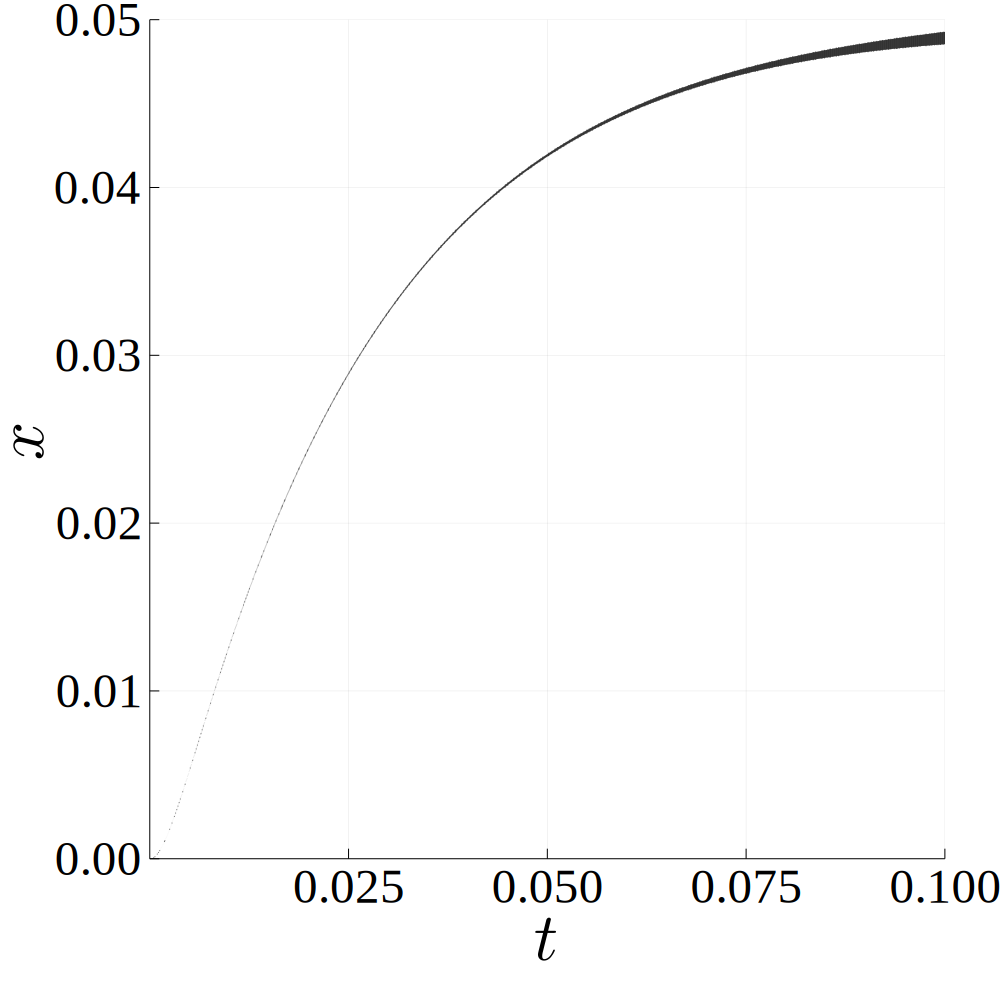

In [102]:
using LaTeXStrings, Plots, Plots.PlotMeasures, LaTeXStrings

fig = Plots.plot()

plot!(fig, [X for X in polys[1:500:end]], color=:black, lw=1.0, linecolor=:black,
    tickfont=font(30, "Times"), guidefontsize=45,
    xlab=L"t",
    ylab=L"x",
    xtick=[0.025, 0.05, 0.075, 0.1], ytick=[0.0, 0.01, 0.02, 0.03, 0.04, 0.05],
    xlims=(0.0, 0.1), ylims=(0.0, 0.05),
    bottom_margin=6mm, left_margin=2mm, right_margin=12mm, top_margin=3mm,
    size=(1000, 1000))

In [103]:
savefig(fig, "ARCH-COMP20-JuliaReach-EMBrake_v1.png")

In [93]:
plot([X for X in polys[1:100:end]], xlab="")

In [95]:
GC.gc()

In [16]:
@time sol_no_pv_no_jit = solve(prob_no_pv_no_jit, max_jumps=1001,
                               alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4));
GC.gc()
@show ρ(eₓ, sol_no_pv_no_jit) 
@show ρ(eₓ, sol_no_pv_no_jit) < x0

  1.323148 seconds (241.69 k allocations: 1.688 GiB, 16.20% gc time)
ρ(eₓ, sol_no_pv_no_jit) = 0.04895073985281849
ρ(eₓ, sol_no_pv_no_jit) < x0 = true


true

In [35]:
tiempos = [@elapsed solve(prob_no_pv_no_jit, max_jumps=1001, alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4)) for _ in 1:5];

In [37]:
mean(tiempos)

0.8160701228

In [ ]:
# plot(sol_no_pv_no_jit, vars=(1, 2), color=:lightblue)

## BRKDC01 (discrete-time)

In [33]:
@time sol_no_pv_no_jit = solve(prob_no_pv_no_jit, max_jumps=1001,
                               alg=GLGM06(δ=1e-7, max_order=1, static=true, dim=4, ngens=4,
                                   approx_model=NoBloating()))
GC.gc()
@show ρ(eₓ, sol_no_pv_no_jit)
ρ(eₓ, sol_no_pv_no_jit) < x0

  0.085722 seconds (100.34 k allocations: 180.522 MiB, 10.14% gc time)
ρ(eₓ, sol_no_pv_no_jit) = 0.04891413127211572


true

In [39]:
sol_no_pv_no_jit = nothing
GC.gc()

In [21]:
@time sol_no_pv_no_jit = solve(prob_no_pv_no_jit, max_jumps=1001,
                               alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4,
                                   approx_model=NoBloating()))
GC.gc()
@show ρ(eₓ, sol_no_pv_no_jit)
ρ(eₓ, sol_no_pv_no_jit) < x0

  1.001981 seconds (90.32 k allocations: 1.652 GiB, 17.79% gc time)
ρ(eₓ, sol_no_pv_no_jit) = 0.04891367692966815


true

In [41]:
tiempos = [@elapsed solve(prob_no_pv_no_jit, max_jumps=1001, alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4, approx_model=NoBloating())) for _ in 1:5];

In [42]:
mean(tiempos)

0.6523566157999999

## BRKNC01

In [48]:
sol_no_pv_with_jit = nothing
GC.gc()

In [45]:
prob_no_pv_with_jit = embrake_no_pv(ζ=[-1e-8, 1e-7], Tsample=1e-4);
@time sol_no_pv_with_jit = solve(prob_no_pv_with_jit, max_jumps=1001,
                                 alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4));

@show ρ(eₓ, sol_no_pv_with_jit)

  1.219349 seconds (268.72 k allocations: 1.696 GiB, 28.32% gc time)
ρ(eₓ, sol_no_pv_with_jit) = 0.04939380910010891


0.04939380910010891

In [49]:
tiempos = [@elapsed solve(prob_no_pv_with_jit, max_jumps=1001, alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4)) for _ in 1:5]

5-element Array{Float64,1}:
 1.686501474
 0.98882438
 0.895205771
 0.596970451
 0.775782747

In [50]:
mean(tiempos)

0.9886569646

## BRKNC01 (discrete-time)

In [54]:
sol_no_pv_with_jit = nothing
GC.gc()

In [53]:
prob_no_pv_with_jit = embrake_no_pv(ζ=[-1e-8, 1e-7], Tsample=1e-4);
@time sol_no_pv_with_jit = solve(prob_no_pv_with_jit, max_jumps=1001,
                                 alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4, approx_model=NoBloating()));

@show ρ(eₓ, sol_no_pv_with_jit)

  1.445757 seconds (179.46 k allocations: 1.664 GiB, 28.31% gc time)
ρ(eₓ, sol_no_pv_with_jit) = 0.04935663367632447


0.04935663367632447

In [55]:
tiempos = [@elapsed solve(prob_no_pv_with_jit, max_jumps=1001, alg=GLGM06(δ=1e-8, max_order=1, static=true, dim=4, ngens=4, approx_model=NoBloating())) for _ in 1:5];

In [56]:
mean(tiempos)

0.9703495066000001

## BRKNP01

In [9]:
sol_no_pv_with_jit = nothing
GC.gc()

In [10]:
prob_pv_1_with_jit = embrake_pv_1(ζ=[-1e-8, 1e-7], Tsample=1e-4);
@time sol_pv_1_with_jit = solve(prob_pv_1_with_jit,
                                alg=ASB07(δ=1e-8, max_order=1, static=true, dim=4, ngens=4), max_jumps=1001);

@show ρ(eₓ, sol_pv_1_with_jit)

 12.170025 seconds (82.67 M allocations: 9.596 GiB, 28.57% gc time)
ρ(eₓ, sol_pv_1_with_jit) = 0.053035688704021304


0.053035688704021304

In [11]:
sfpos = []
times = []

for fp in sol_pv_1_with_jit
    for (j, X) in enumerate(fp)
        push!(sfpos, ρ(eₓ, X))
        push!(times, tspan(fp, j))
    end
end

In [12]:
length(sfpos)

10031021

In [14]:
idx = findfirst(x -> x > x0, sfpos)

8242288

In [16]:
times[idx-1]

[0.0823323, 0.0823324]

In [18]:
sfpos[idx-1]

0.049999999650880166

In [32]:
# mal, o mas bien produce un resultado conservativo
#sf = [ρ(eₓ, X) for X in sol_pv_1_with_jit];
#times = [tspan(X) for X in sol_pv_1_with_jit];

## BRKNP01 (discrete-time)

In [7]:
sol_no_pv_with_jit = nothing
GC.gc()

In [8]:
prob_pv_1_with_jit = embrake_pv_1(ζ=[-1e-8, 1e-7], Tsample=1e-4);
@time sol_pv_1_with_jit = solve(prob_pv_1_with_jit, max_jumps=1001,
                                alg=ASB07(δ=1e-8, max_order=1, static=true, dim=4, ngens=4, approx_model=NoBloating()));

@show ρ(eₓ, sol_pv_1_with_jit)

 12.017275 seconds (82.27 M allocations: 9.559 GiB, 28.62% gc time)
ρ(eₓ, sol_pv_1_with_jit) = 0.05299530421184598


0.05299530421184598

In [10]:
typeof(sol_pv_1_with_jit)

ReachabilityAnalysis.ReachSolution{HybridFlowpipe{Float64,ReachSet{Float64,Zonotope{Float64,StaticArrays.SArray{Tuple{4},Float64,1,4},StaticArrays.SArray{Tuple{4,4},Float64,2,16}}},ShiftedFlowpipe{Flowpipe{Float64,ReachSet{Float64,Zonotope{Float64,StaticArrays.SArray{Tuple{4},Float64,1,4},StaticArrays.SArray{Tuple{4,4},Float64,2,16}}},SubArray{ReachSet{Float64,Zonotope{Float64,StaticArrays.SArray{Tuple{4},Float64,1,4},StaticArrays.SArray{Tuple{4,4},Float64,2,16}}},1,Array{ReachSet{Float64,Zonotope{Float64,StaticArrays.SArray{Tuple{4},Float64,1,4},StaticArrays.SArray{Tuple{4,4},Float64,2,16}}},1},Tuple{UnitRange{Int64}},true}},Float64}},ASB07{Float64,NoBloating{Val{:base},Val{:lazy}},ReachabilityAnalysis.GIR05,Val{true},Val{true},Val{4},Val{4}}}

In [14]:
sfpos = []
times = []

for fp in sol_pv_1_with_jit
    for (j, X) in enumerate(fp)
        push!(sfpos, ρ(eₓ, X))
        push!(times, tspan(fp, j))
    end
end

In [16]:
idx = findfirst(x -> x > x0, sfpos)

8255669

In [17]:
times[idx - 1]

[0.082466, 0.0824661]

In [19]:
sfpos[idx-1]

0.04999999909697095